In [12]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as sgeometry
import cartopy.crs as ccrs

# spatial
import xarray as xa
import pandas as pd
import geopandas as gpd
import dask_geopandas as daskgpd
import rasterio
from rasterio import features as featuresio
from rasterio.enums import MergeAlg

# custom
from reeftruth import plotting, resampling

unep_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/reeftruth/data/gdcr/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
degrees_resolution = 1/3600

LATS = [-10, 0]
LONS = [130, 140]

CROPPED_LONS_LIM = [145.4, 146]
CROPPED_LATS_LIM = [-10.4, -9.9]

WHOLE_LATS = [-32, 0]
WHOLE_LONS = [130, 170]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
unep_xa = get_data(config_fp)

NameError: name 'get_data' is not defined

In [ ]:
# def generate_unep_xarray(
#     LATS: list[float, float] = [-90, 90],
#     LONS: list[float, float] = [-180, 180],
#     degrees_resolution: float = 15 / 3600,  # 15 arcseconds (gebco resolution)
# ):
#     # check if unep xarray already exists
#     res_str = replace_dot_with_dash(str(round(degrees_resolution, 3)))

#     unep_xa_dir = Path(config.gt_data_dir) / "unep_wcmc/rasters"
#     unep_xa_dir.mkdir(parents=True, exist_ok=True)
#     unep_fps = list(unep_xa_dir.glob("*.nc"))

#     # correct resolution
#     correct_resolutions = find_files_for_resolution(unep_fps, res_str)
#     unep_xas = cmipper_file_ops.find_files_for_area(correct_resolutions, LATS, LONS)

#     if len(unep_xas) >= 1:
#         print(f"Loading UNEP xarray at {degrees_resolution:.03f} degrees resolution.")
#         return xa.open_dataset(unep_xas[0]).sel(latitude=slice(*LATS), longitude=slice(*LONS))
#     else:
#         print("loading UNEP data...")
#         unep_fp = (
#             Path(config.gt_data_dir)
#             / "unep_wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
#         )
#         # load unep tabular data. Don't dask yet to allow filtering by region (if required)
#         # unep_gdf = gpd.read_file(unep_fp).cx[LATS[0] : LATS[1], LONS[0] : LONS[1]]
#         unep_gdf = daskgpd.read_file(unep_fp, npartitions=4)
#         geometry_filter = sgeometry.box(min(LONS), min(LATS), max(LONS), max(LATS))
#         filtered_gdf = unep_gdf[unep_gdf.geometry.intersects(geometry_filter)]

#         print(
#             f"generating UNEP raster at {degrees_resolution:.03f} degrees resolution..."
#         )
#         # generate gt raster
#         # Purist: defined here as the mean (lat/lon) value maximum resolution (30m) the UNEP data at the equator
#         # degrees_resolution = spatial_data.distance_to_degrees(
#         #     distance_lat=452, approx_lat=0, approx_lon=0
#         # )[-1]
#         # for now, resolution of global bathymetry
#         # generating a raster necessitates a resolution of grid cell.
#         unep_raster = rasterize_geodf(filtered_gdf, resolution=degrees_resolution)

#         print("casting raster to xarray...")
#         # generate gt xarray
#         unep_xa = raster_to_xarray(
#             unep_raster,
#             x_y_limits=lat_lon_vals_from_geo_df(filtered_gdf)[:4],
#             resolution=degrees_resolution,
#             name="UNEP_GDCR",
#         ).chunk("auto")

#         # generate filepath and save
#         spatial_extent_info = cmipper_lat_lon_string_from_tuples(LATS, LONS).upper()
#         unep_xa_fp = unep_xa_dir / f"unep_{res_str}_{spatial_extent_info}.nc"
#         print(f"saving UNEP raster to {unep_xa_fp}...")
#         unep_xa.to_netcdf(unep_xa_fp)

#         return unep_xa.to_dataset()

In [9]:
def rasterize_geodf(
    geo_df: gpd.geodataframe,
    resolution: float = 1.0,
    all_touched: bool = True,
    merge_alg: MergeAlg = MergeAlg.replace,
) -> np.ndarray:
    """Rasterize a geodataframe to a numpy array.

    Args:
        geo_df (gpd.geodataframe): Geodataframe to rasterize
        resolution (float): Resolution of the raster in degrees

    Returns:
        np.ndarray: Rasterized numpy array
    TODO: add crs customisation. Probably from class object elsewhere.
    Currently assumes EPSG:4326.
    """

    xmin, ymin, xmax, ymax, width, height = lat_lon_vals_from_geo_df(
        geo_df, resolution
    )
    # Create the transform based on the extent and resolution
    transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)
    transform.crs = rasterio.crs.CRS.from_epsg(4326)

    # Any chance of a loading bar? No: would have to dig into the function istelf.
    # could be interesting...
    return featuresio.rasterize(
        [(shape, 1) for shape in geo_df["geometry"]],
        out_shape=(height, width),
        transform=transform,
        fill=0, # not nan since integer, and want to have negative target (0)
        all_touched=all_touched,    # argument to be made that this doesn't best reflect suitability
        dtype=rasterio.uint16,  # updated since was reaching upper limit of uint8
        merge_alg=merge_alg,
    )


def lat_lon_vals_from_geo_df(geo_df: gpd.geodataframe, resolution: float = 1.0):
    # Calculate the extent in degrees from bounds of geometry objects
    lon_min, lat_min, lon_max, lat_max = geo_df["geometry"].total_bounds
    # Calculate the width and height of the raster in pixels based on the extent and resolution
    width = int((lon_max - lon_min) / resolution)
    height = int((lat_max - lat_min) / resolution)

    return lon_min, lat_min, lon_max, lat_max, width, height



def raster_to_xarray(
    raster: np.ndarray,
    x_y_limits: np.ndarray,
    resolution: float = 1.0,
    name: str = "raster_cast_to_xarray",
) -> xa.DataArray:
    """Convert a raster to an xarray DataArray.

    Args:
        raster (np.ndarray): Raster to convert
        resolution (float): Resolution of the raster in degrees

    Returns:
        xa.DataArray: DataArray of the raster
    TODO: add attributes kwarg
    """

    lon_min, lat_min, lon_max, lat_max = x_y_limits
    cell_width = int((lon_max - lon_min) / resolution)
    cell_height = int((lat_max - lat_min) / resolution)

    # Create longitude and latitude arrays
    longitudes = np.linspace(lon_min, lon_max, cell_width)
    # reversed because raster inverted
    latitudes = np.linspace(lat_max, lat_min, cell_height)

    # Create an xarray DataArray with longitude and latitude coordinates
    xa_array = xa.DataArray(
        raster,
        coords={"latitude": latitudes, "longitude": longitudes},
        dims=["latitude", "longitude"],
        name=name,
    )
    # Set the CRS (coordinate reference system) if needed
    # TODO: make kwarg
    xa_array.attrs["crs"] = "EPSG:4326"  # Example CRS, use the appropriate CRS
    # TODO: set attributes if required
    #     attrs=dict(
    #         description="Rasterised Reef Check coral presence survey data"
    #     ))
    return xa_array




# Thoughts

- ~~Are maximum values getting squashed to 255 because of int8?~~ 
    - Yes! Now fixed
- ~~Raster -> DataArray seems to behave~~
- How does the resolution to which the thing is sampled make a difference?
    - When rasterizing to the "native" resolution (30m), you get values [0, 1, 2, 3, 4] in diminishing proportions. This is due to double-counting of reef presence/overlapping polygons. Now changed behaviour (see below)
    - Resampling at bathymetric resolution (~15 times as coarse as native) gives noticeably jagged edges: but really won't be going higher-resolution than this in the foreseeable future, so it's fine. Most importantly it doesn't seem to lose any detail due to the `all_touch = True` argument to the merging algorithm.

    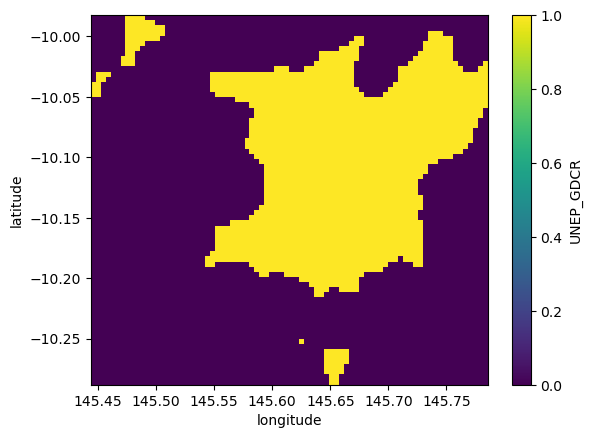

- ~~Number of rows in dataframe should equal number of counts in DataArray~~
    - Unfortunately not true since dataframe is (multi-)shape objects (not squares)
- Some rows contain multipolygons which span vast areas. These multipolygons can be expanded using the `df.explode` attribute. This should technically be done before limiting it to an area, but in practice works best by doing it before and after (first: approximate restriction but doesn't miss anything out, second: correct restriction)
```
study len multi-polygons: 329
study len polygons: 8321
whole len multi-polygons: 2318
whole len polygons: 57138
```
# Thoughts

- ~~Are maximum values getting squashed to 255 because of int8?~~ 
    - Yes! Now fixed
- ~~Raster -> DataArray seems to behave~~
- How does the resolution to which the thing is sampled make a difference?
    - When rasterizing to the "native" resolution (30m), you get values [0, 1, 2, 3, 4] in diminishing proportions. This is due to double-counting of reef presence/overlapping polygons. Now changed behaviour (see below)
    - Resampling at bathymetric resolution (~15 times as coarse as native) gives noticeably jagged edges: but really won't be going higher-resolution than this in the foreseeable future, so it's fine. Most importantly it doesn't seem to lose any detail due to the `all_touch = True` argument to the merging algorithm.

    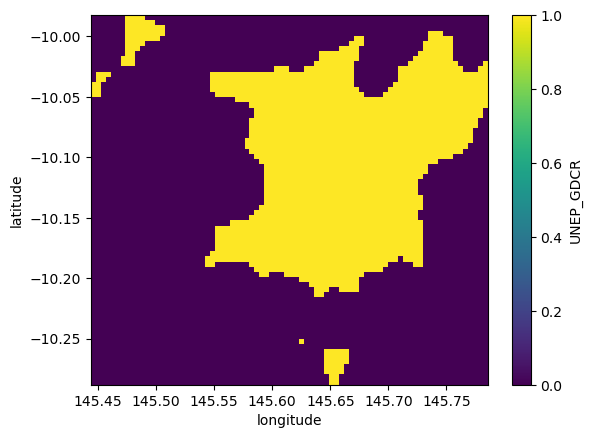

- ~~Number of rows in dataframe should equal number of counts in DataArray~~
    - Unfortunately not true since dataframe is (multi-)shape objects (not squares)
- Some rows contain multipolygons which span vast areas. These multipolygons can be expanded using the `df.explode` attribute. This should technically be done before limiting it to an area, but in practice works best by doing it before and after (first: approximate restriction but doesn't miss anything out, second: correct restriction)

## To do:
- ~~Plot distribution~~
- ~~Find single example of e.g. atoll by zooming in~~
- ~~Isolate in dataframe~~
- ~~Rasterize cropped dataframe~~
- ~~Count squares~~

### Observations
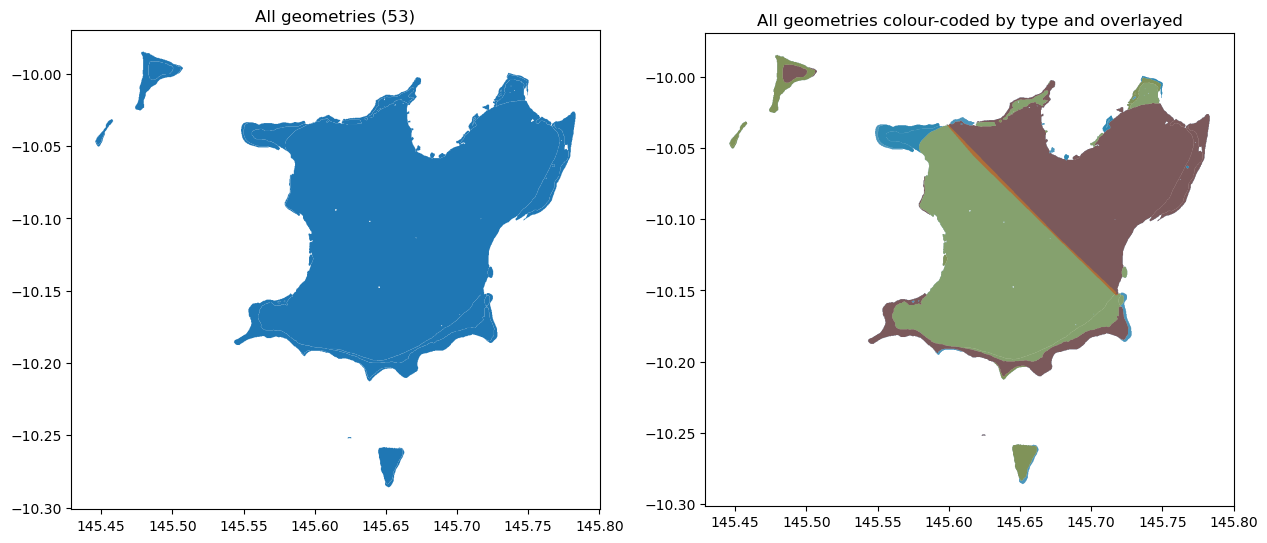

Much overlayed coral. This overlap counts up when rasterised.

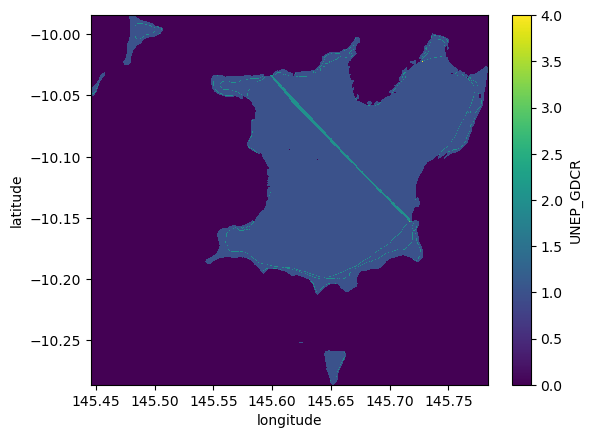

Two approaches:
- Count overlapping areas as particularly suitable (multiple coral counts) – this is what I've inadvertantly been doing so far. But it seems disingenuous since the sampling technique involves double-counting
- Count it all just as reef presence (1). This is achieved by switching the MergeAlg from "add" to "replace". Like so:

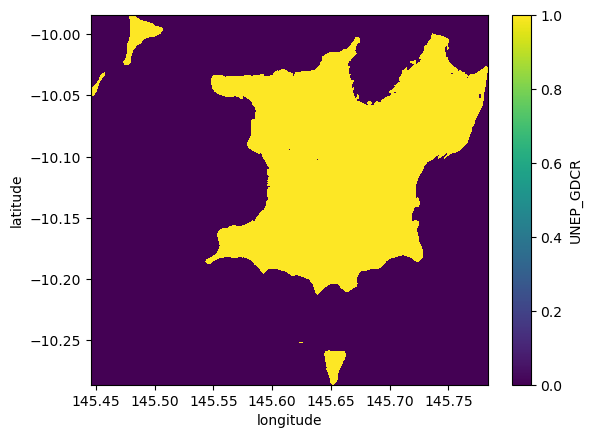

In [13]:
# load unep tabular data. Don't dask yet to allow filtering by region (if required)
# unep_gdf = gpd.read_file(unep_fp).cx[LATS[0] : LATS[1], LONS[0] : LONS[1]]
unep_gdf = daskgpd.read_file(unep_fp, npartitions=4)
study_geometry_filter = sgeometry.box(min(LONS), min(LATS), max(LONS), max(LATS))
whole_geometry_filter = sgeometry.box(min(WHOLE_LONS), min(WHOLE_LATS), max(WHOLE_LONS), max(WHOLE_LATS))
study_filtered_gdf = unep_gdf[unep_gdf.geometry.intersects(study_geometry_filter)]
whole_filtered_gdf = unep_gdf[unep_gdf.geometry.intersects(whole_geometry_filter)]

### Exploding dask df


In [14]:
print("study len multi-polygons:", len(study_filtered_gdf.compute()))
print("study len polygons:", len(study_filtered_gdf.compute().explode(index_parts=True)))
print("whole len multi-polygons:", len(whole_filtered_gdf.compute()))
print("whole len polygons:", len(whole_filtered_gdf.compute().explode(index_parts=True)))

study len multi-polygons: 329
study len polygons: 8321
whole len multi-polygons: 2318
whole len polygons: 57138


In [16]:
unep_raster = rasterize_geodf(study_filtered_gdf, resolution=degrees_resolution)

print("casting raster to xarray...")
# generate gt xarray
unep_xa = raster_to_xarray(
    unep_raster,
    x_y_limits=lat_lon_vals_from_geo_df(study_filtered_gdf)[:4],
    resolution=degrees_resolution,
    name="UNEP_GDCR",
).chunk("auto")

casting raster to xarray...


[None, None]

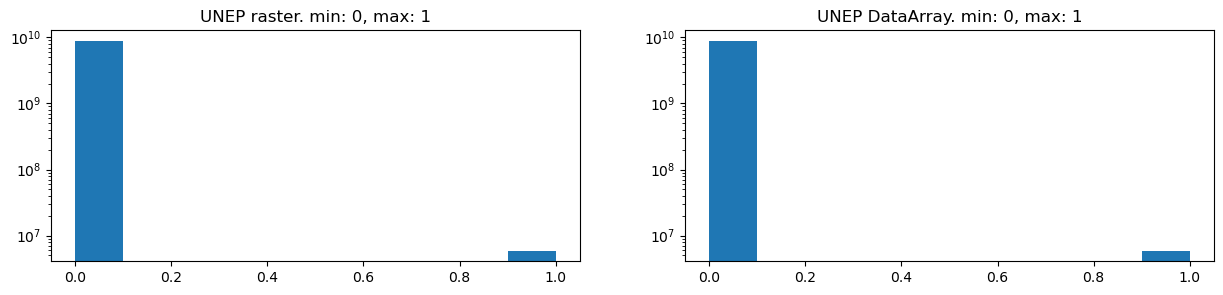

In [19]:
f, ax = plt.subplots(ncols=2, figsize=(15, 3))
ax[0].hist(unep_raster.flatten());
ax[1].hist(unep_xa.values.flatten());
ax[0].set_title(f"UNEP raster. min: {np.min(unep_raster)}, max: {np.max(unep_raster)}")
ax[1].set_title(f"UNEP DataArray. min: {np.min(unep_xa.values)}, max: {np.max(unep_xa.values)}")
[a.set_yscale("log") for a in ax]

In [20]:
cropped_filtered_df = daskgpd.read_file(unep_fp, npartitions=4)
geometry_filter = sgeometry.box(min(CROPPED_LONS_LIM), min(CROPPED_LATS_LIM), max(CROPPED_LONS_LIM), max(CROPPED_LATS_LIM))
cropped_filtered_df = unep_gdf[unep_gdf.geometry.intersects(geometry_filter)].compute()
cropped_filtered_df.head()

(-10.4, -9.9)

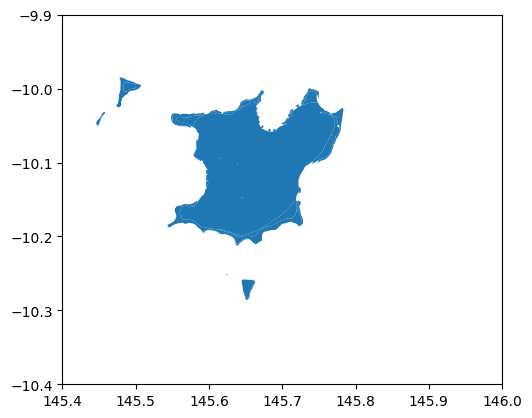

In [22]:
cropped_filtered_df.plot()
plt.xlim(CROPPED_LONS_LIM)
plt.ylim(CROPPED_LATS_LIM)

In [23]:
cropped_unep_raster = rasterize_geodf(cropped_filtered_df, resolution=degrees_resolution)

print("casting raster to xarray...")
# generate gt xarray
cropped_unep_xa = raster_to_xarray(
    cropped_unep_raster,
    x_y_limits=lat_lon_vals_from_geo_df(cropped_filtered_df)[:4],
    resolution=degrees_resolution,
    name="UNEP_GDCR",
) # not chunking for now

casting raster to xarray...


(-10.4, -9.9)

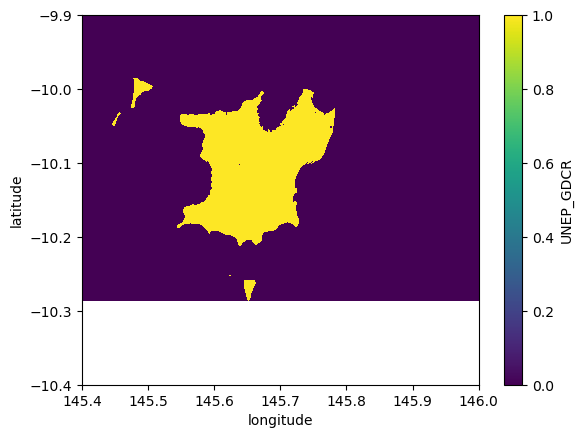

In [24]:
cropped_unep_xa.plot()
plt.xlim(CROPPED_LONS_LIM)
plt.ylim(CROPPED_LATS_LIM)

In [25]:
cropped_filtered_df = daskgpd.read_file(unep_fp, npartitions=4).compute()
exploded_cropped_filtered_df = cropped_filtered_df.explode(index_parts=True)
geometry_filter = sgeometry.box(min(CROPPED_LONS_LIM), min(CROPPED_LATS_LIM), max(CROPPED_LONS_LIM), max(CROPPED_LATS_LIM))
exploded_cropped_filtered_df = exploded_cropped_filtered_df[exploded_cropped_filtered_df.geometry.intersects(geometry_filter)]

Text(0.5, 1.0, 'All geometries colour-coded by type and overlayed')

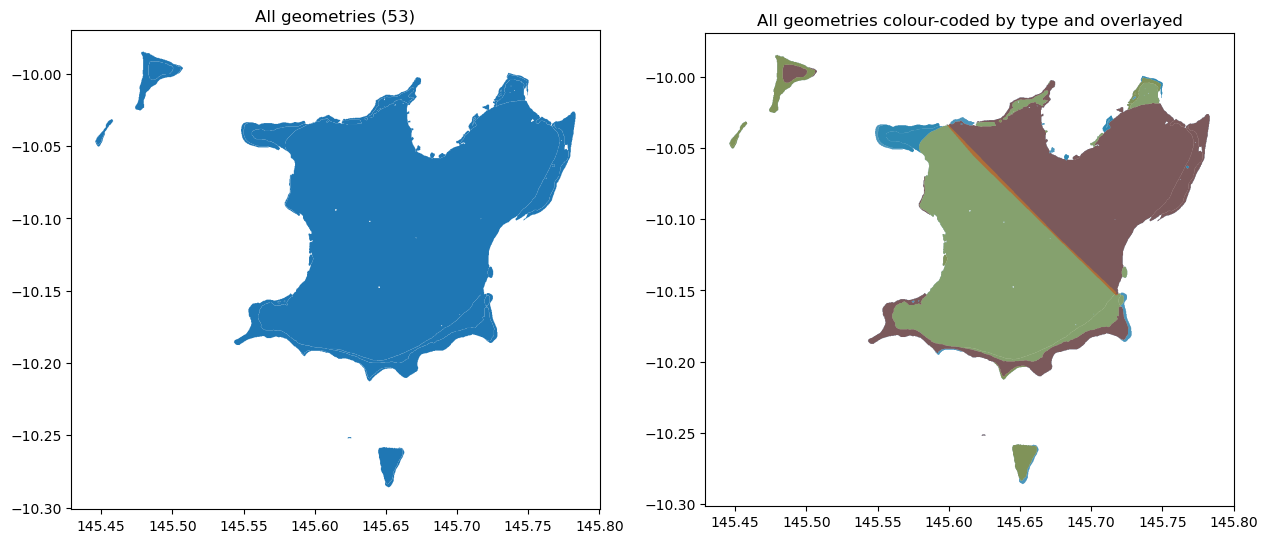

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15,8))
exploded_cropped_filtered_df.plot(ax=ax[0])
colors = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#d83c04", "#d83c04"]
# exploded_cropped_filtered_df.geometry.plot(ax=ax[1], color=[colors[i//5] for i in range(len(exploded_cropped_filtered_df))])
exploded_cropped_filtered_df.geometry.plot(ax=ax[1])

# plot each geometry object in exploded_cropped a different color (there are 53 unique geometries)
for i, geom in enumerate(exploded_cropped_filtered_df.geometry):
    # print(i//5)
    gpd.GeoSeries(geom).plot(ax=ax[1], color=colors[i%5], alpha=0.5)

ax[0].set_title("All geometries (53)")
ax[1].set_title("All geometries colour-coded by type and overlayed")

In [27]:
cropped_exploded_unep_raster = rasterize_geodf(exploded_cropped_filtered_df, resolution=degrees_resolution)

print("casting raster to xarray...")
# generate gt xarray
cropped_exploaded_unep_xa = raster_to_xarray(
    cropped_exploded_unep_raster,
    x_y_limits=lat_lon_vals_from_geo_df(exploded_cropped_filtered_df)[:4],
    resolution=degrees_resolution,
    name="UNEP_GDCR",
) # not chunking for now

casting raster to xarray...


<GeoAxes: title={'center': 'Only cells with centroid in coral cast to 1. Raster resolution = 15 arcseconds (GEBCO)'}, xlabel='longitude', ylabel='latitude'>

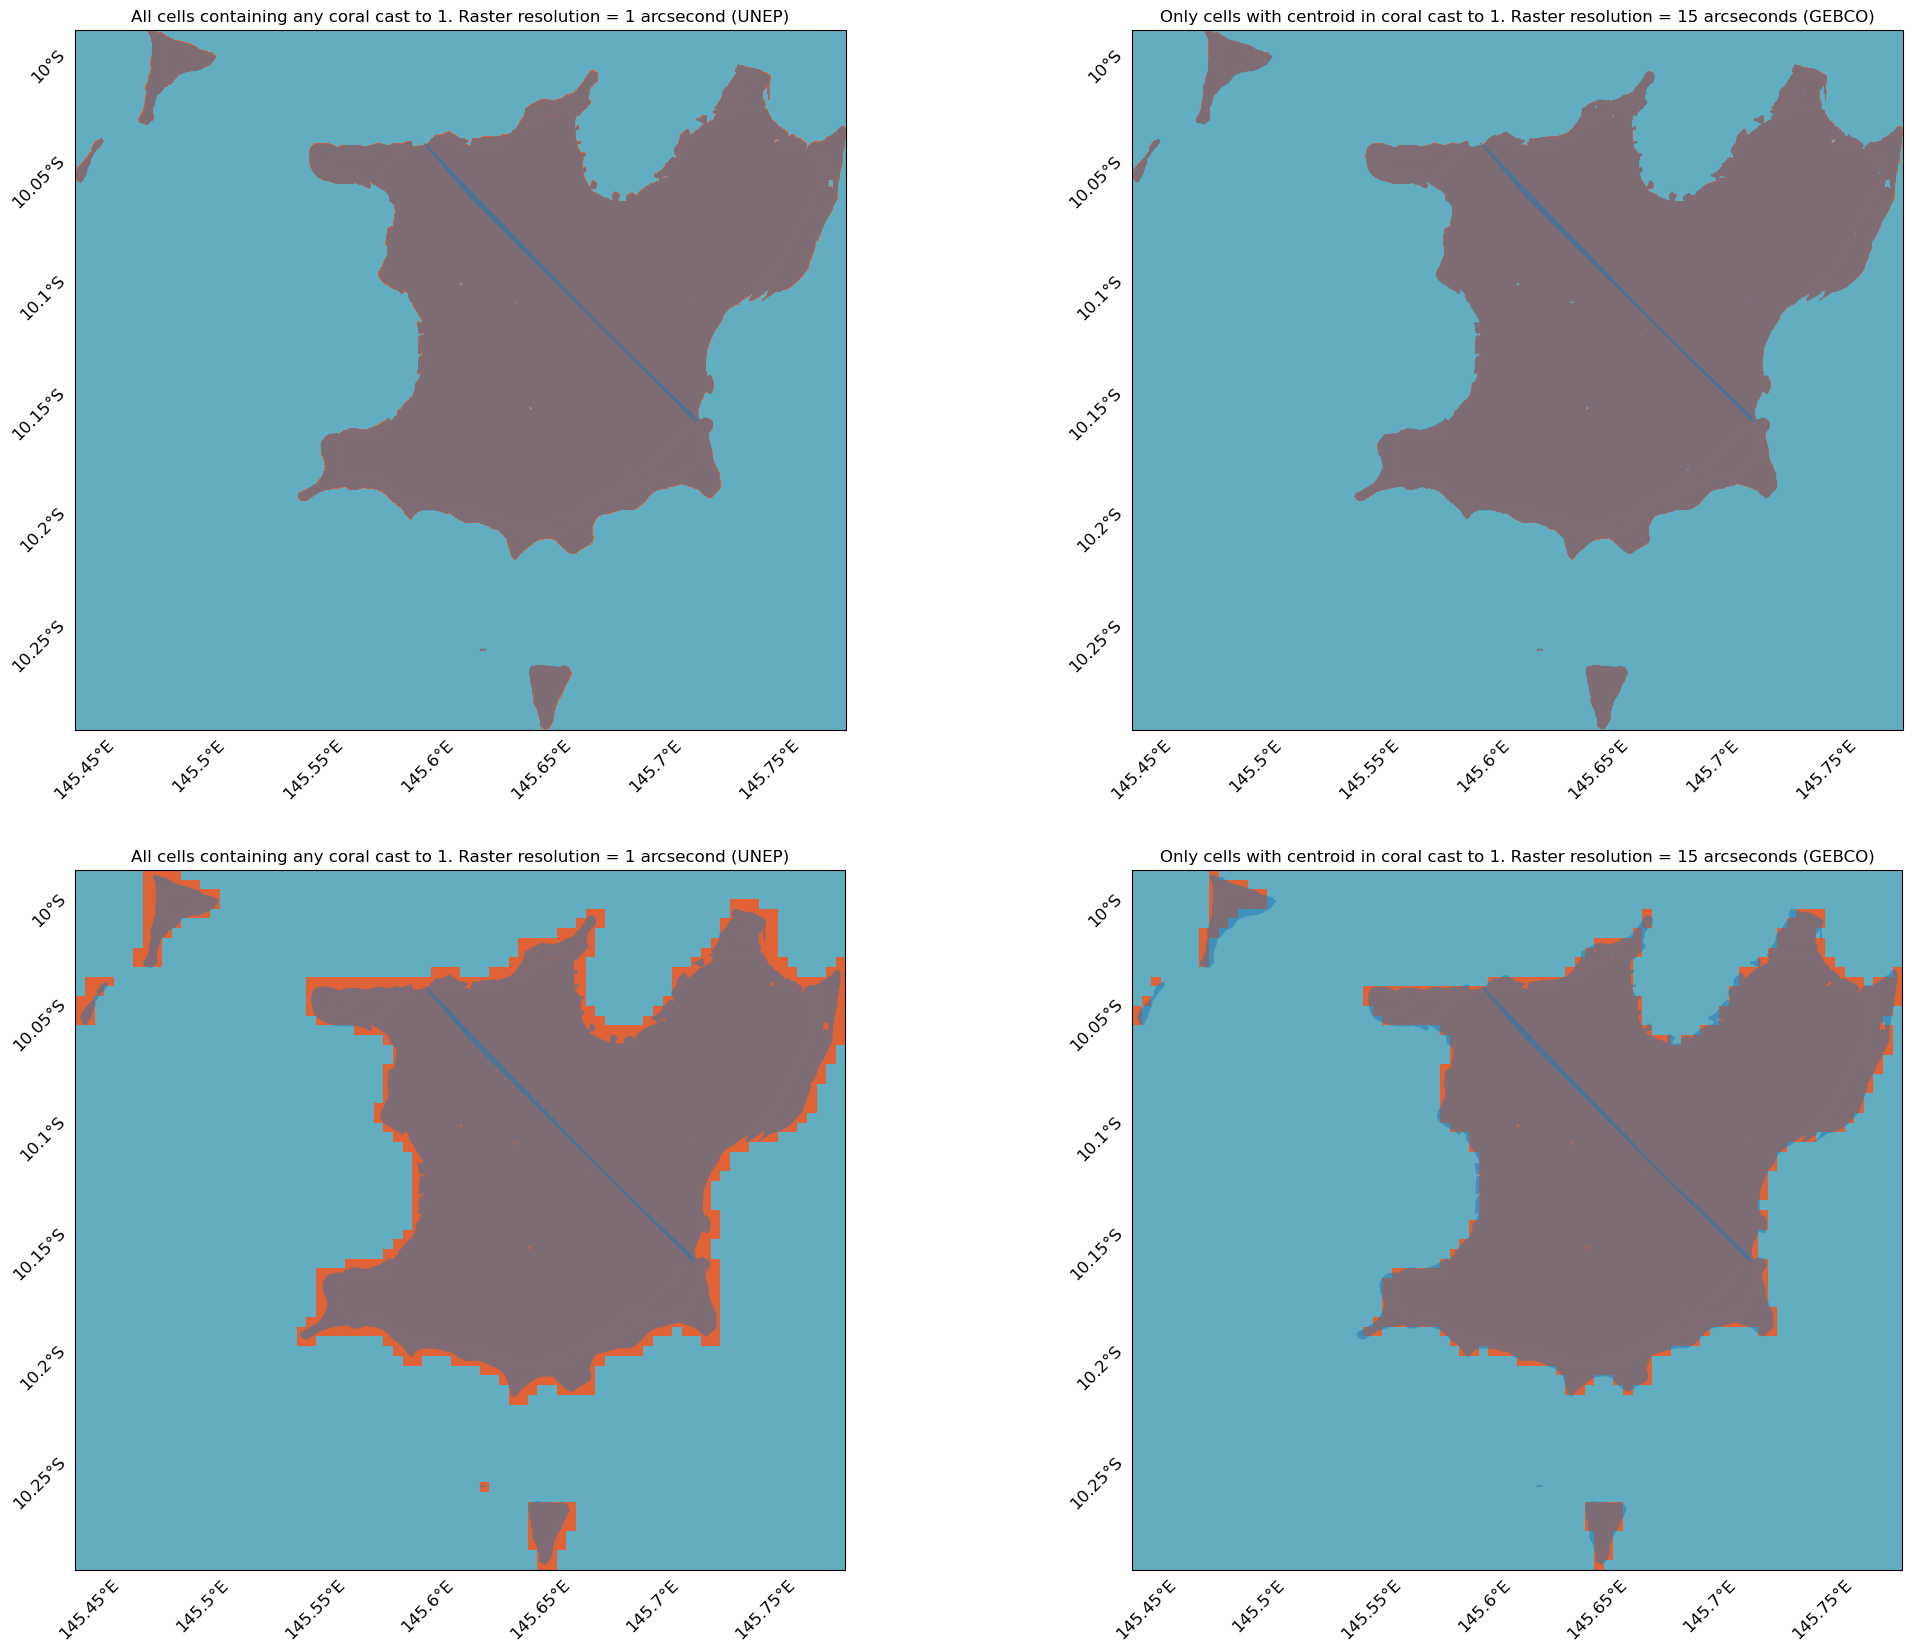

In [28]:
bath_res = 15/3600
native_res = 1/3600
bath_xa_unep_at = raster_to_xarray(rasterize_geodf(exploded_cropped_filtered_df, resolution=bath_res, all_touched=True), lat_lon_vals_from_geo_df(exploded_cropped_filtered_df)[:4], resolution=bath_res, name="UNEP_GDCR_bath")
native_xa_unep_at = raster_to_xarray(rasterize_geodf(exploded_cropped_filtered_df, resolution=native_res, all_touched=True), lat_lon_vals_from_geo_df(exploded_cropped_filtered_df)[:4], resolution=native_res, name="UNEP_GDCR_bath")
bath_xa_unep = raster_to_xarray(rasterize_geodf(exploded_cropped_filtered_df, resolution=bath_res, all_touched=False), lat_lon_vals_from_geo_df(exploded_cropped_filtered_df)[:4], resolution=bath_res, name="UNEP_GDCR_bath")
native_xa_unep = raster_to_xarray(rasterize_geodf(exploded_cropped_filtered_df, resolution=native_res, all_touched=False), lat_lon_vals_from_geo_df(exploded_cropped_filtered_df)[:4], resolution=native_res, name="UNEP_GDCR_bath")


f, ax = plt.subplots(ncols=2, nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(25, 20))
# plotting.plot_spatial(bath_xa_unep_at, fax=(f,ax[0]), alpha=0.5, title=None)
plotting.plot_spatial(native_xa_unep_at, fax=(f,ax[0,0]), alpha=0.8, title="All cells containing any coral cast to 1. Raster resolution = 1 arcsecond (UNEP)", cbar_dict={"cbar": False})
exploded_cropped_filtered_df.plot(ax=ax[0,0], alpha=0.5)
plotting.plot_spatial(bath_xa_unep_at, fax=(f,ax[1,0]), alpha=0.8, title="All cells containing any coral cast to 1. Raster resolution = 1 arcsecond (UNEP)", cbar_dict={"cbar": False})
exploded_cropped_filtered_df.plot(ax=ax[1,0], alpha=0.5)

plotting.plot_spatial(native_xa_unep, fax=(f,ax[0,1]), alpha=0.8, title="Only cells with centroid in coral cast to 1. Raster resolution = 15 arcseconds (GEBCO)", cbar_dict={"cbar": False})
exploded_cropped_filtered_df.plot(ax=ax[0,1], alpha=0.5)
plotting.plot_spatial(bath_xa_unep, fax=(f,ax[1,1]), alpha=0.8, title="Only cells with centroid in coral cast to 1. Raster resolution = 15 arcseconds (GEBCO)", cbar_dict={"cbar": False})
exploded_cropped_filtered_df.plot(ax=ax[1,1], alpha=0.5)


In [52]:
from haversine import inverse_haversine, Direction
start_point = (-10, 145)
new_point = haversine.inverse_haversine(start_point, 1, Direction.NORTH)
# degrees = new_point 

In [57]:
degrees_resolution = np.abs(np.mean(tuple(a - b for a, b in zip(start_point, new_point))))
degrees_resolution

0.004496601818622992

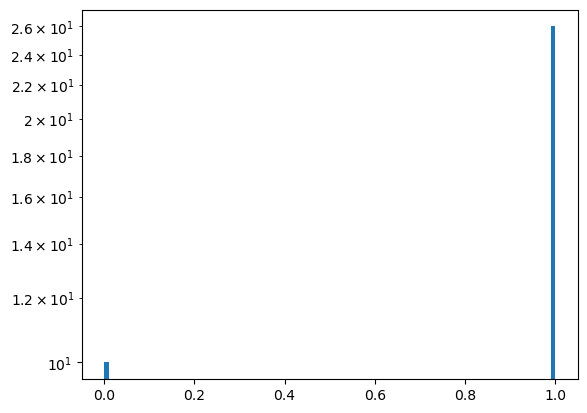

In [66]:
bath_xa_1km = raster_to_xarray(rasterize_geodf(exploded_cropped_filtered_df, resolution=0.05, all_touched=True), lat_lon_vals_from_geo_df(exploded_cropped_filtered_df)[:4], resolution=0.05, name="UNEP_GDCR_bath")
plt.hist(bath_xa_1km.values.flatten(), bins=np.linspace(0,1, 100))
plt.yscale('log')

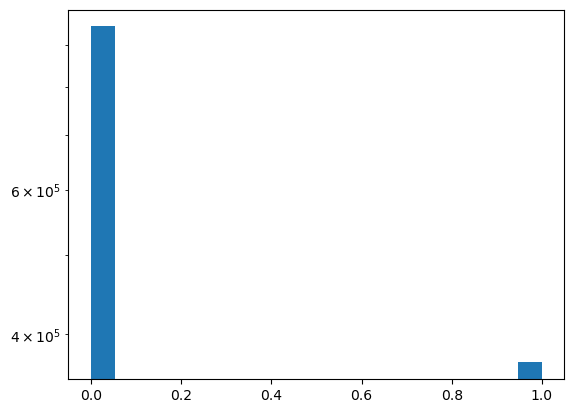

In [40]:
plt.hist(native_xa_unep.values.flatten(), bins=np.linspace(0,1, 20))
plt.yscale('log')

# WRI

In [29]:
# load unep tabular data. Don't dask yet to allow filtering by region (if required)
# wri_gdf = gpd.read_file(wri_fp).cx[LATS[0] : LATS[1], LONS[0] : LONS[1]]

wri_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/reeftruth/data/WRI_REEF_EXTENT/Reefs/reef_500_poly.shp"
wri_gdf = daskgpd.read_file(wri_fp, npartitions=4)
wri_gdf = wri_gdf.explode()
study_geometry_filter = sgeometry.box(min(LONS), min(LATS), max(LONS), max(LATS))
# whole_geometry_filter = sgeometry.box(min(WHOLE_LONS), min(WHOLE_LATS), max(WHOLE_LONS), max(WHOLE_LATS))
study_filtered_gdf = wri_gdf[wri_gdf.geometry.intersects(study_geometry_filter)]
# whole_filtered_gdf = wri_gdf[wri_gdf.geometry.intersects(whole_geometry_filter)]

/Users/rt582/miniforge3/envs/reeftruth/lib/python3.12/site-packages/dask/dataframe/core.py:7175: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [30]:
wri_gdf['centroid'] = wri_gdf.centroid
wri_gdf['centroid_x'] = wri_gdf.centroid.x
wri_gdf['centroid_y'] = wri_gdf.centroid.y

# Sort by centroid x (longitude) and y (latitude) coordinates
sorted_wri_gdf = wri_gdf.sort_values(by=['centroid_x', 'centroid_y'], ascending=[True, False]).compute()

/Users/rt582/miniforge3/envs/reeftruth/lib/python3.12/site-packages/dask/core.py:127: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return func(*(_execute_task(a, cache) for a in args))


In [31]:
# wri_gdf.compute()
# rasterize_geodf(wri_gdf)
wri_gdf["geometry"].total_bounds

dask.array<total_bounds-agg, shape=(4,), dtype=float64, chunksize=(4,), chunktype=numpy.ndarray>

In [32]:
study_filtered_gdf.compute()

/Users/rt582/miniforge3/envs/reeftruth/lib/python3.12/site-packages/dask/core.py:127: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return func(*(_execute_task(a, cache) for a in args))
/Users/rt582/miniforge3/envs/reeftruth/lib/python3.12/site-packages/dask/core.py:127: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return func(*(_execute_task(a, cache) for a in args))


,,GRIDCODE,geometry


In [33]:
# select first 10 rows
# wri_gdf
wri_gdf.head(10)

GRIDCODE                                           geometry  \
0 0         1  POLYGON ((-9401007.067 -3358385.332, -9401007....   
  1         1  POLYGON ((-4553507.067 -3318885.332, -4553007....   
  2         1  POLYGON ((-4553507.067 -3318885.332, -4554007....   
  3         1  POLYGON ((-4553507.067 -3318385.332, -4553507....   
  4         1  POLYGON ((-4554007.067 -3317385.332, -4554507....   
  5         1  POLYGON ((-4556507.067 -3313885.332, -4556507....   
  6         1  POLYGON ((-4555007.067 -3161885.332, -4555007....   
  7         1  POLYGON ((-4550007.067 -3115385.332, -4550007....   
  8         1  POLYGON ((-9584507.067 -3063385.332, -9584507....   
  9         1  POLYGON ((-9572007.067 -3061385.332, -9572007....   

                              centroid    centroid_x    centroid_y  
0 0  POINT (-9406716.326 -3361839.036) -9.406716e+06 -3.361839e+06  
  1  POINT (-4553257.067 -3319135.332) -4.553257e+06 -3.319135e+06  
  2  POINT (-4553757.067 -3318635.332) -4.553757e+06 -3.318635e+06  
  3  POINT (-4553257.067 -3317885.332) -4.553257e+06 -3.317885e+06  
  4  POINT (-4557154.794 -3317675.105) -4.557155e+06 -3.317675e+06  
  5  POINT (-4556257.067 -3313635.332) -4.556257e+06 -3.313635e+06  
  6  POINT (-4555920.860 -3166001.711) -4.555921e+06 -3.166002e+06  
  7  POINT (-4553302.265 -3118711.603) -4.553302e+06 -3.118712e+06  
  8  POINT (-9584327.559 -3066516.479) -9.584328e+06 -3.066516e+06  
  9  POINT (-9571382.067 -3060322.832) -9.571382e+06 -3.060323e+06

plotting...


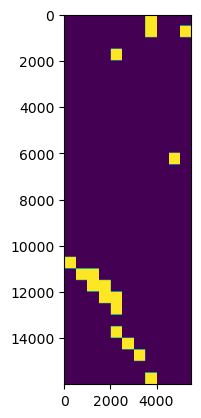

In [34]:
raster = rasterize_geodf(sorted_wri_gdf.head(10))   # breaks at larger numbers

print("plotting...")
plt.imshow(raster)

In [35]:

# read_adf_file("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/potentially_useful/Base_Data/Reefs/reef_500/dblbnd.adf")
raster = read_adf_file("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/potentially_useful/Base_Data/Reefs/reef_500/hdr.adf")[0]

NameError: name 'read_adf_file' is not defined

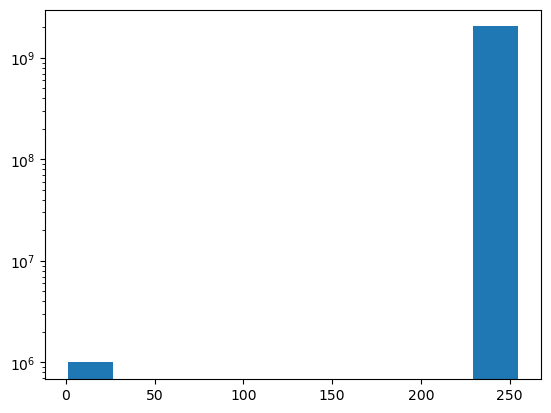

In [ ]:
plt.hist(out[0].flatten())
plt.yscale("log")

In [ ]:
out[1]

{'driver': 'AIG', 'dtype': 'uint8', 'nodata': 255.0, 'width': 80150, 'height': 25456, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["CYLINDRICAL",UNIT["METERS",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(500.0, 0.0, -20037507.067162,
       0.0, -500.0, 6364114.668074), 'blockysize': 4, 'tiled': False}

In [ ]:
from pathlib import Path
from pyproj import CRS


def read_adf_file(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        profile = src.profile  # Get metadata about the file

    return data, profile


def wri_binary_to_raster(adf_fp: Path | str, name: str = "WRI_REEF_EXTENT"):
    wri_reef_extent_lat_range = [-89.999882, 89.999882]
    wri_reef_extent_lon_range = [-180, 180]

    binary_data, profile = read_adf_file(Path(adf_fp))

    lat_res = (wri_reef_extent_lat_range[1] - wri_reef_extent_lat_range[0]) / profile["height"]
    lon_res = (wri_reef_extent_lon_range[1] - wri_reef_extent_lon_range[0]) / profile["width"]

    latitudes = np.linspace(min(wri_reef_extent_lat_range), max(wri_reef_extent_lat_range), binary_data.shape[0])
    longitudes = np.linspace(min(wri_reef_extent_lon_range), max(wri_reef_extent_lon_range), binary_data.shape[1])

    # Create longitude and latitude arrays
    # longitudes = np.arange(min(wri_reef_extent_lon_range), max(wri_reef_extent_lon_range), lon_res)
    # # reversed because raster inverted
    # latitudes = np.arange(max(wri_reef_extent_lat_range), min(wri_reef_extent_lat_range), -lat_res)
    # Create an xarray DataArray with longitude and latitude coordinates
    xa_array = xa.DataArray(
        binary_data,
        coords={"latitude": latitudes, "longitude": longitudes},
        dims=["latitude", "longitude"],
        name=name,
    )
    # cast values of 255 to be np.nan
    xa_array = xa_array.where(xa_array != 255)

    # Set the CRS (coordinate reference system) if needed
    # TODO: make kwarg
    # xa_array.attrs["crs"] = "EPSG:4326"  # Example CRS, use the appropriate CRS

    crs_wkt = 'LOCAL_CS["CYLINDRICAL",UNIT["METERS",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
    crs = CRS.from_wkt(crs_wkt)
    return xa_array

# out = wri_binary_to_raster("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/potentially_useful/Base_Data/Reefs/reef_500/hdr.adf")  # nothing on gbr
out = wri_binary_to_raster("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/potentially_useful/Base_Data/Reefs/reef_500/w001000.adf")

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.0058° (~627 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x3403fce00>)

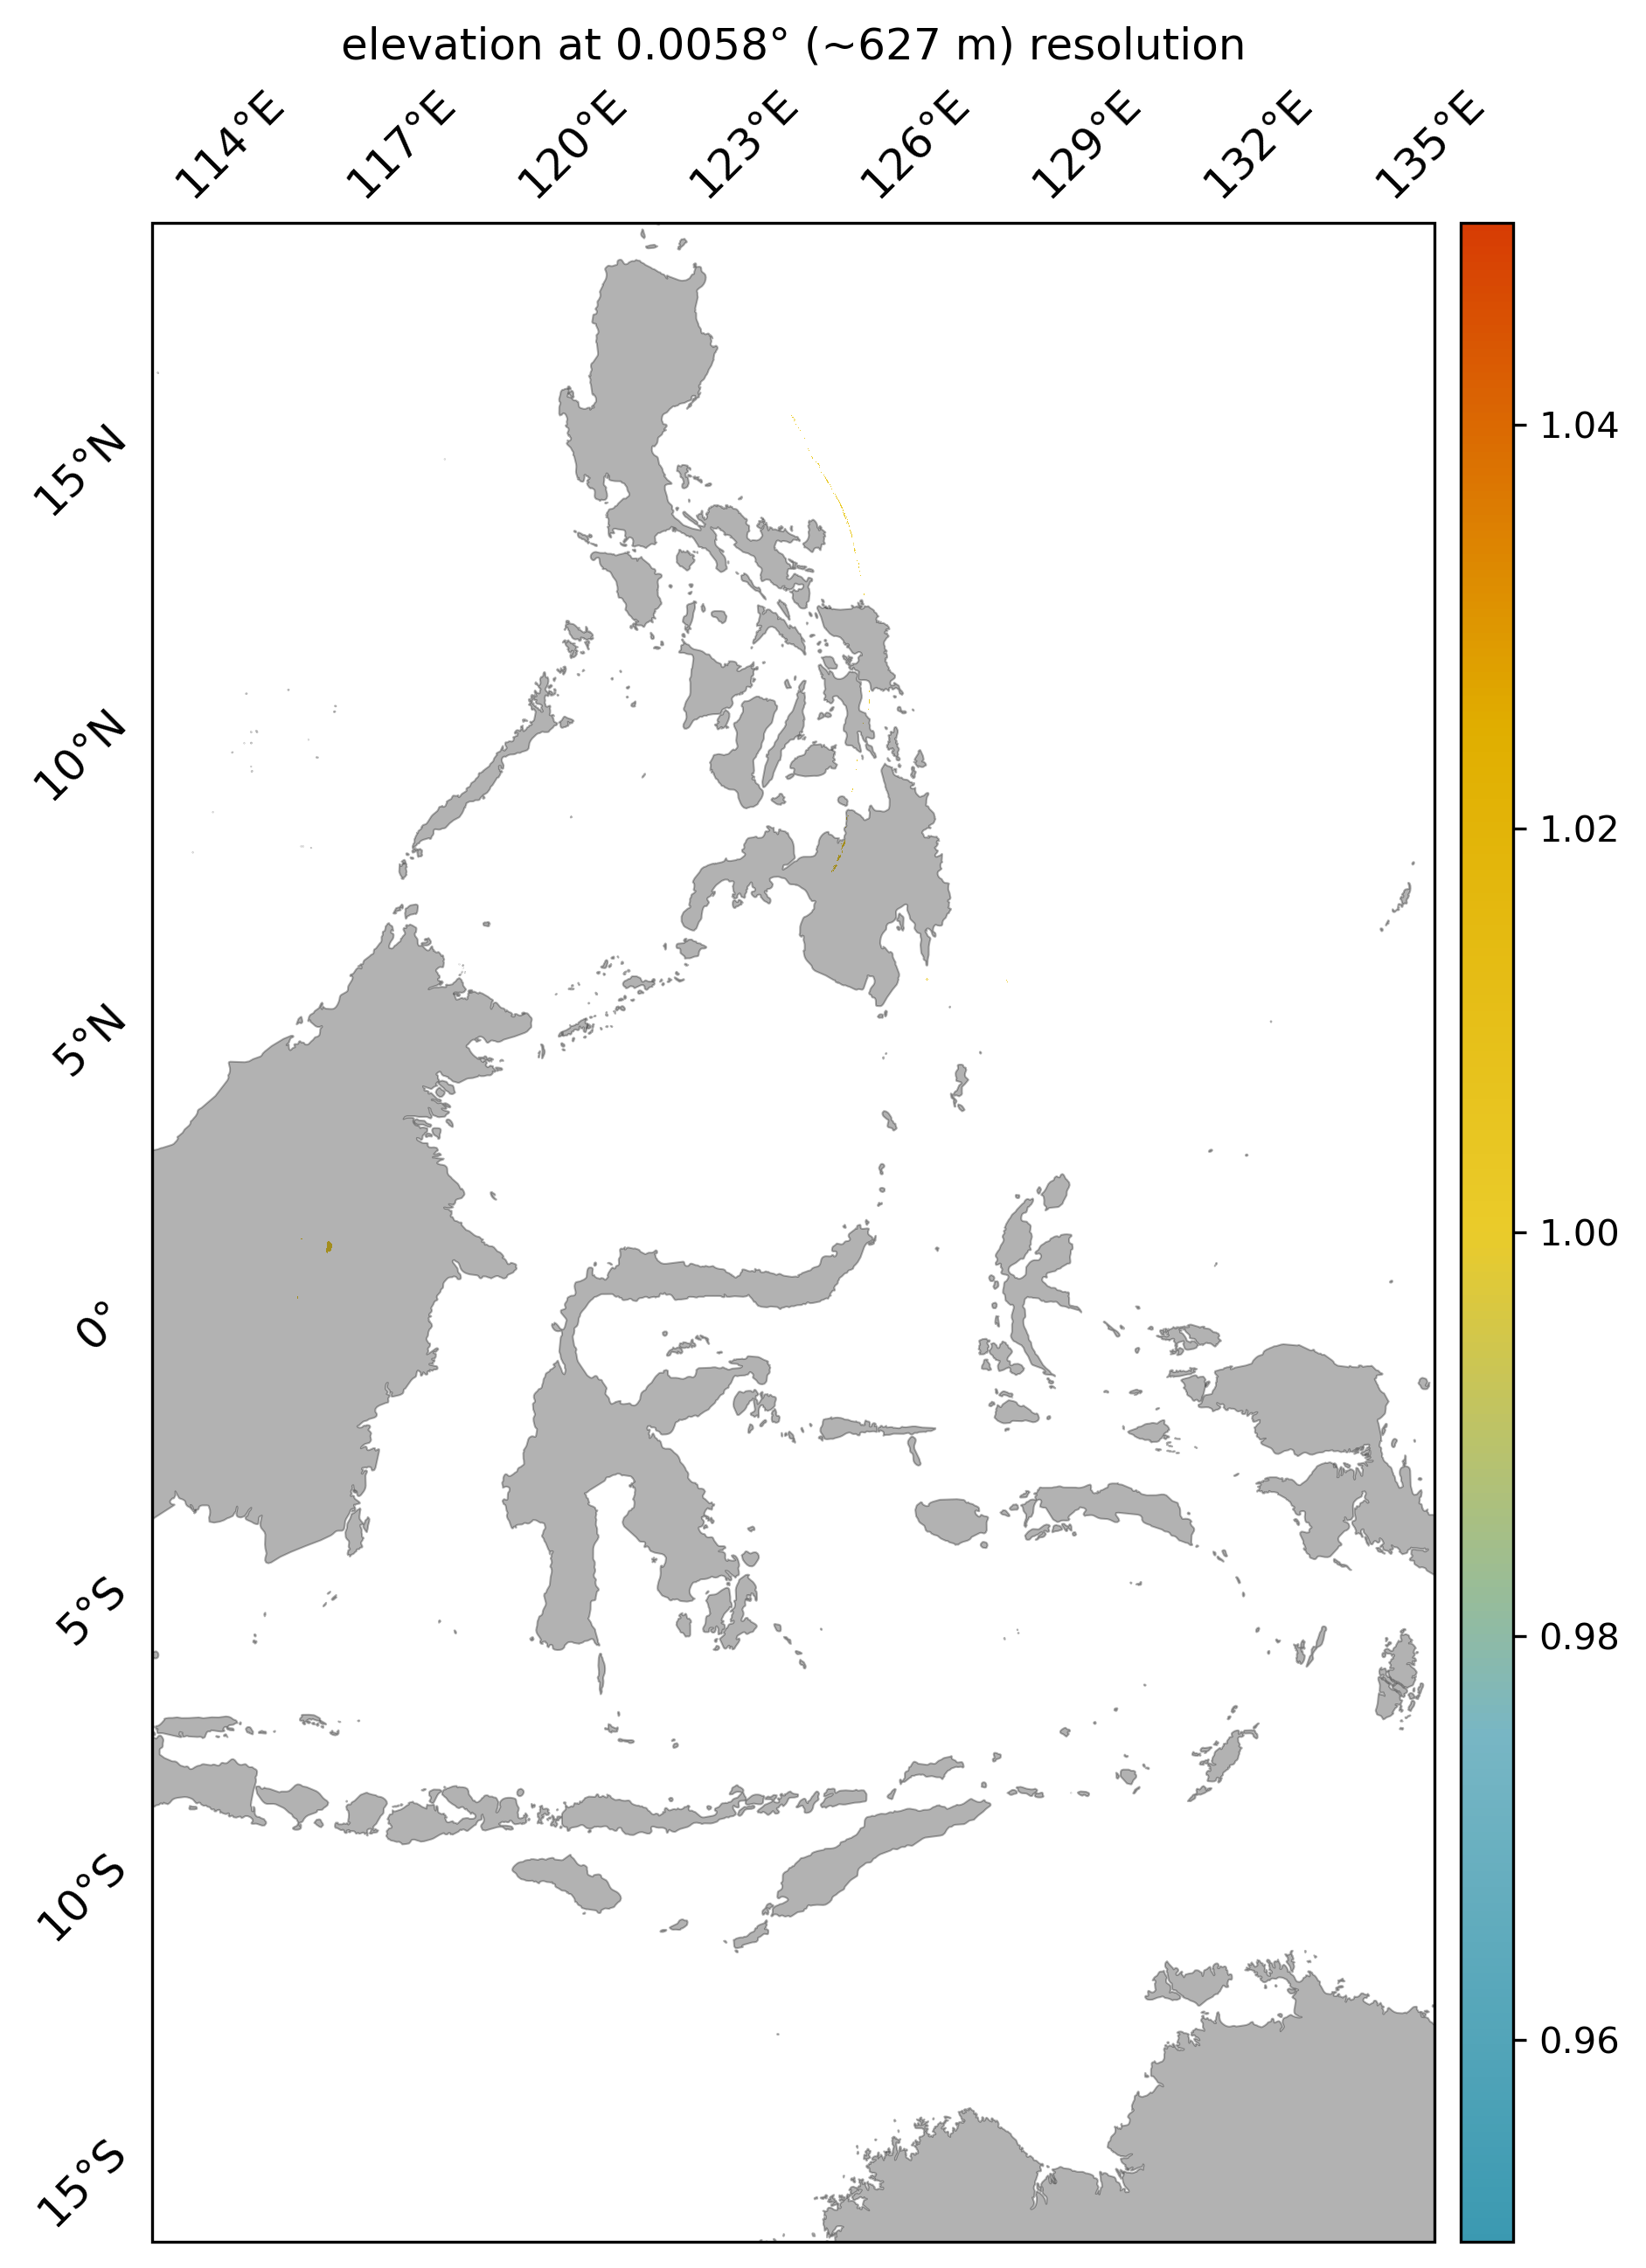

In [ ]:
plotting.plot_spatial(ds["elevation"].isel(latitude=slice(-15000, -10000), longitude=slice(-15000,-10000)))

In [ ]:
from pathlib import Path
adf_fps = Path("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/reeftruth/data/WRI_REEF_EXTENT/Reefs/reef_500").glob("*.adf")

for adf_fp in adf_fps:
    binary_data, profile = read_adf_file(Path(adf_fp))
    try:
        # print(profile["height"])
        # print(profile["width"])
        print(adf_fp.name)
        print(profile)
        print("\n")
    except:
        print("height or width not in adf file")

vat.adf
{'driver': 'AIG', 'dtype': 'uint8', 'nodata': 255.0, 'width': 80150, 'height': 25456, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["CYLINDRICAL",UNIT["METERS",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(500.0, 0.0, -20037507.067162,
       0.0, -500.0, 6364114.668074), 'blockysize': 4, 'tiled': False}


z001002x.adf
{'driver': 'AIG', 'dtype': 'uint8', 'nodata': 255.0, 'width': 80150, 'height': 25456, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["CYLINDRICAL",UNIT["METERS",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(500.0, 0.0, -20037507.067162,
       0.0, -500.0, 6364114.668074), 'blockysize': 4, 'tiled': False}


z001001.adf
{'driver': 'AIG', 'dtype': 'uint8', 'nodata': 255.0, 'width': 80150, 'height': 25456, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["CYLINDRICAL",UNIT["METERS",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(500.0, 0.0, -20037507.067162,
       0.0, -500.0, 6364114.668074), 'blockysize': 4

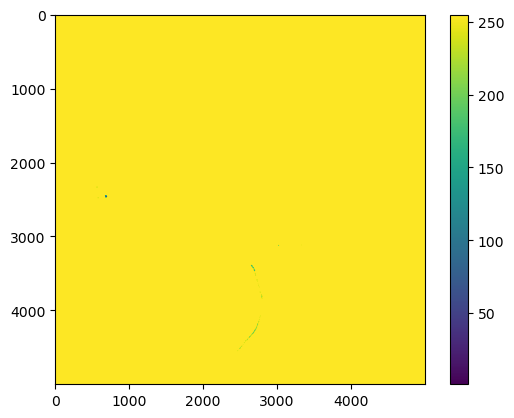

In [ ]:
plt.imshow(raster[-15000:-10000,-15000:-10000])
plt.colorbar()

In [ ]:
with rasterio.open("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/potentially_useful/Base_Data/Reefs/reef_500/w001000.adf") as src:
    data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs

    # Extract metadata
    height = src.height
    width = src.width
    nodata = src.nodata

# Generate coordinates using the affine transformation
x_coords = np.linspace(-180, 180, width)
y_coords = np.linspace(-89.999882, 89.999882, height)

# Create the xarray DataArray
elevation = xa.DataArray(
    data,
    dims=["latitude", "longitude"],
    coords={"latitude": y_coords, "longitude": x_coords},
    name="elevation"
)

# Assign the CRS to the DataArray
elevation.attrs["crs"] = crs.to_wkt()

# Handle the nodata values if necessary
elevation = elevation.where(elevation != nodata, np.nan)

# Create the xarray Dataset (optional, if you need to work with a Dataset)
ds = xa.Dataset({"elevation": elevation})



In [ ]:
ds

<xarray.Dataset> Size: 16GB
Dimensions:    (latitude: 25456, longitude: 80150)
Coordinates:
  * latitude   (latitude) float64 204kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
  * longitude  (longitude) float64 641kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    elevation  (latitude, longitude) float64 16GB nan nan nan ... nan nan nan

In [ ]:
print(np.sum(raster[raster != 255]))
print(np.sum(out.values[out.values != 255]))

998853
998853


In [ ]:
out

<xarray.DataArray 'WRI_REEF_EXTENT' (latitude: 25456, longitude: 80150)> Size: 2GB
array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
Coordinates:
  * latitude   (latitude) float64 204kB 90.0 89.99 89.99 ... -89.99 -89.99
  * longitude  (longitude) float64 641kB -180.0 -180.0 -180.0 ... 180.0 180.0
Attributes:
    crs:      EPSG:4326

In [ ]:
resolution = 
lon_min, lat_min, lon_max, lat_max = [-180, -90, 180, 90]
cell_width = int((lon_max - lon_min) / resolution)
cell_height = int((lat_max - lat_min) / resolution)

# Create longitude and latitude arrays
longitudes = np.linspace(lon_min, lon_max, cell_width)
# reversed because raster inverted
latitudes = np.linspace(lat_max, lat_min, cell_height)

# Create an xarray DataArray with longitude and latitude coordinates
xa_array = xa.DataArray(
    raster,
    coords={"latitude": latitudes, "longitude": longitudes},
    dims=["latitude", "longitude"],
    name=name,
)
# Set the CRS (coordinate reference system) if needed
# TODO: make kwarg
xa_array.attrs["crs"] = "EPSG:4326"  # Example CRS, use the appropriate CRS
# TODO: set attributes if required
#     attrs=dict(
#         description="Rasterised Reef Check coral presence survey data"
#     ))
return xa_array

In [ ]:
3410114.668074 / 500

6820.229336148001

In [ ]:
wri_gdf.iloc[11].geometry

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

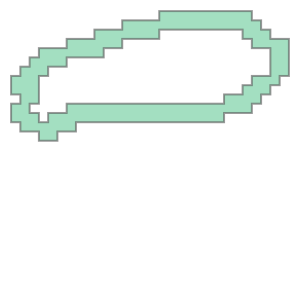

In [ ]:
wri_gdf.iloc[0].geometry

# Spark workshop 
What custom-built frameworks for large training ML?

QGIS/ArcGIS don't handle large datasets well

### Parallel
- Multithreading / Slurm
- Spark and dask (pure python equivalent of spark). Can often just swap the tasks between the two. Dask has very little/no support for raster data types. Spark has fully-fledged geospatial version, Sedona


GEE particularly good at raster data: Sedona works best on tabular (e.g. point) datasets

### Spark
- Can seamlessly pass messages between multithreaded processes